# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *

Using TensorFlow backend.


## Options

In [2]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)
    train_feats = [var for x in train_feats for var in train_feats[x]]

In [3]:
n_models = 10
patience = 2
max_epochs = 200

ensemble_size = 10
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam', 'trainable':True}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwish2', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 31 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
train_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'train.hdf5', "r+"), rot_mult=2)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


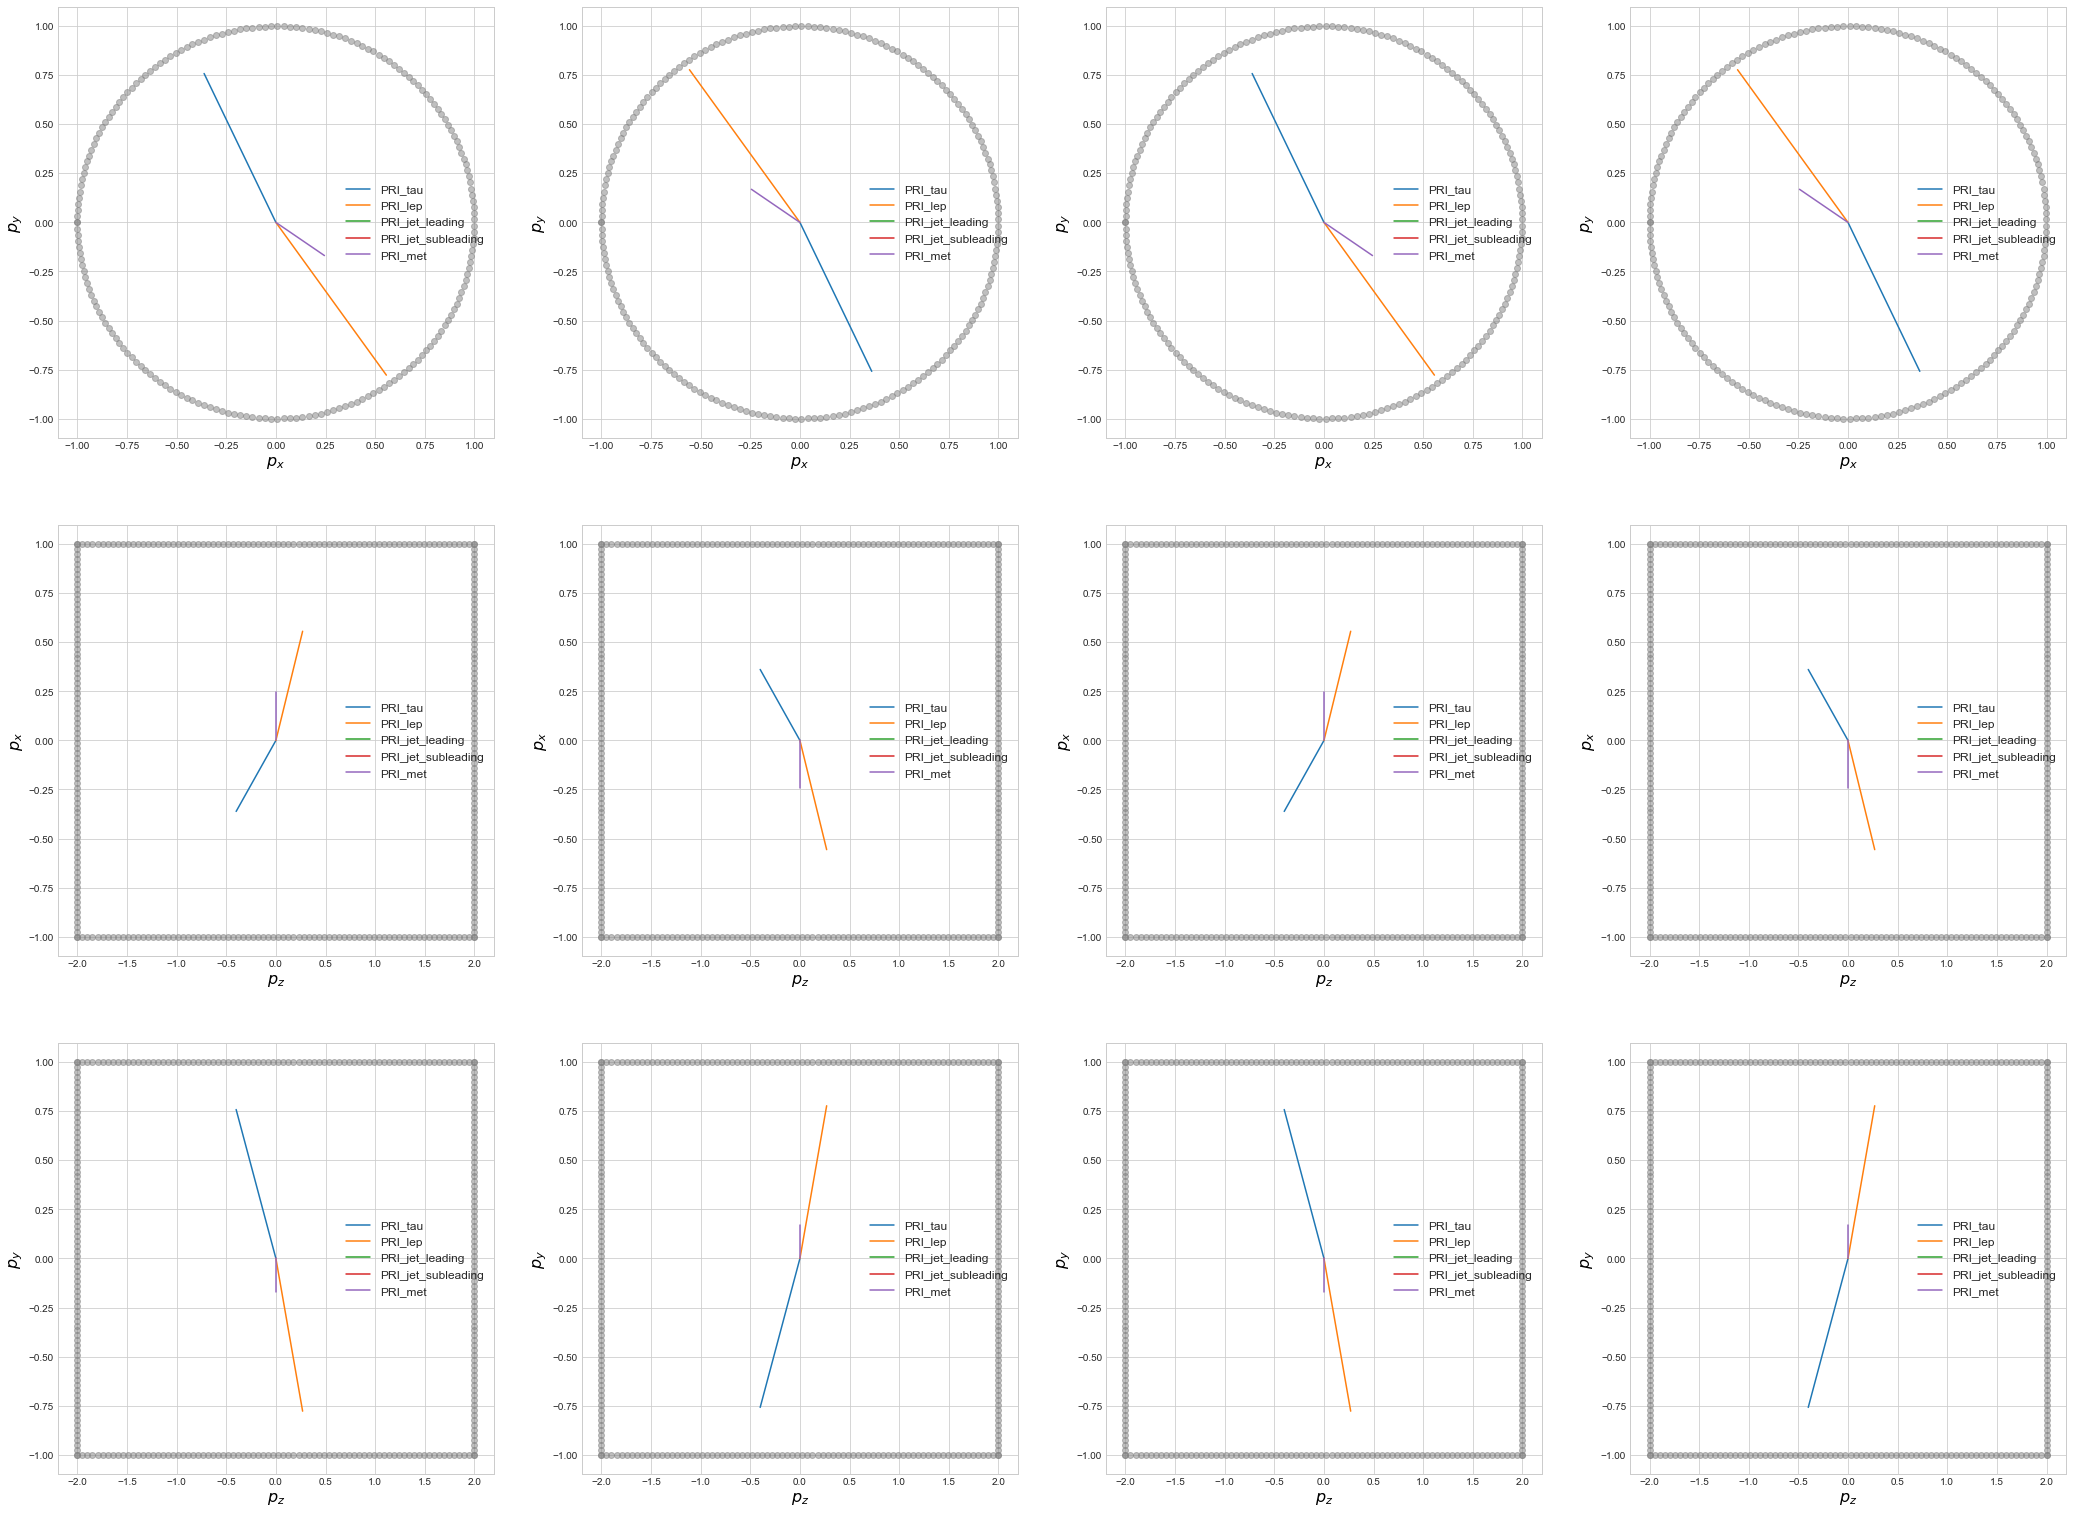

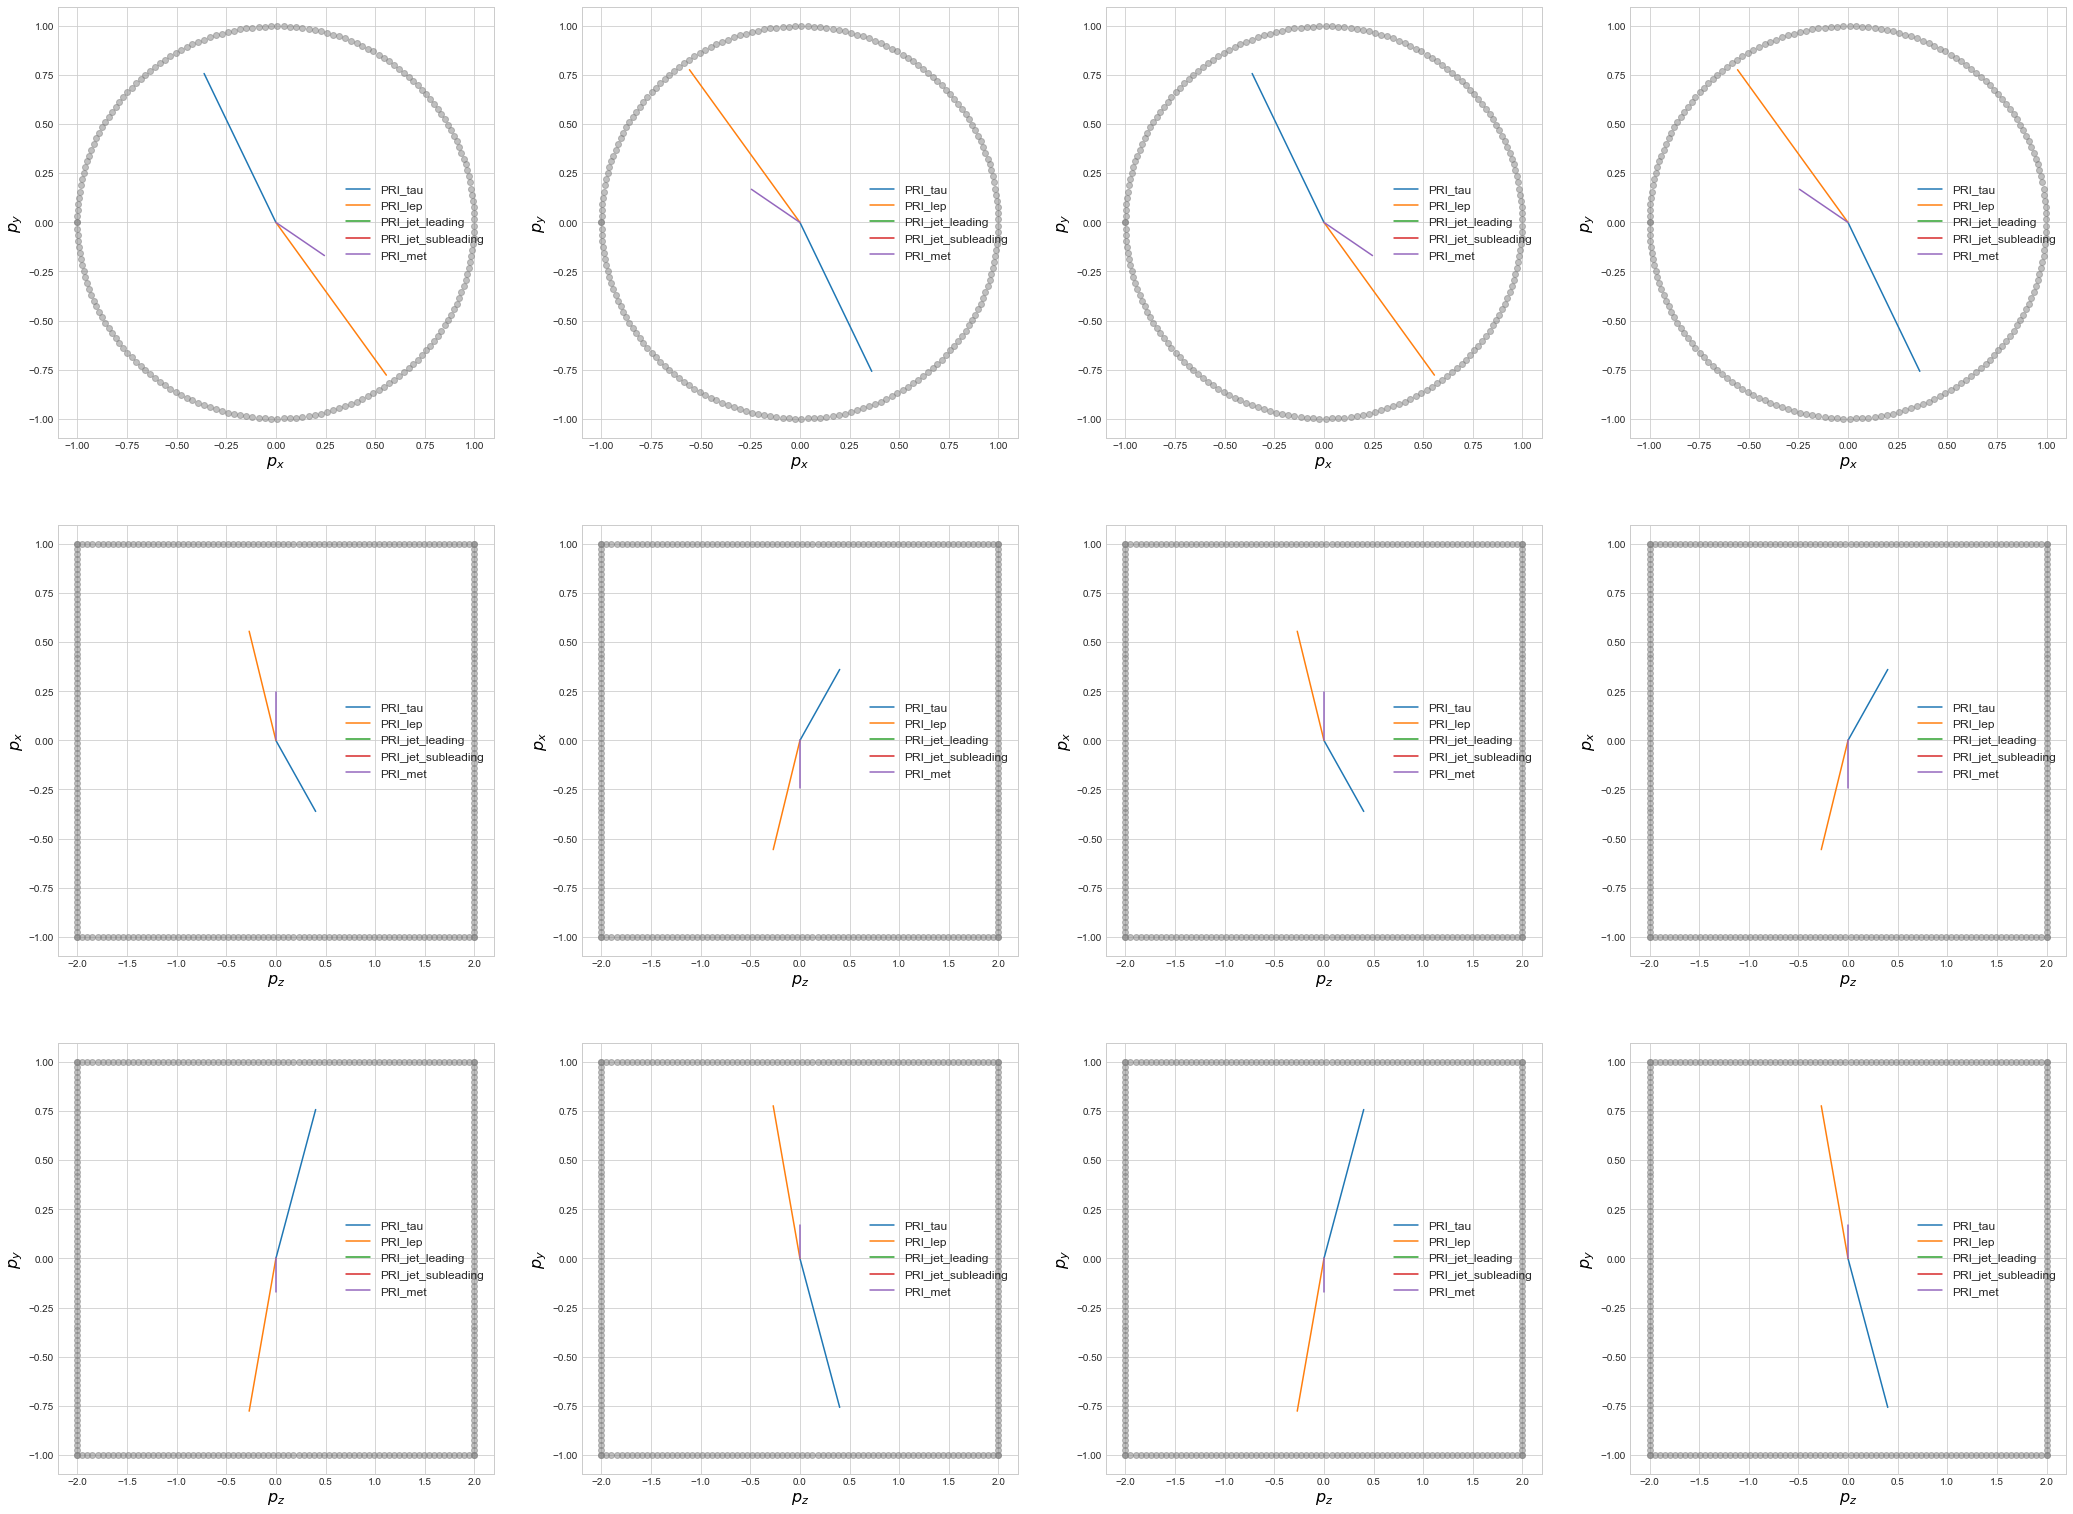

In [5]:
id=3
aug_ranges = [range(4), range(4,8)]
for aug_range in aug_ranges:
    comp_events([pd.DataFrame(train_fy.get_test_fold(0, i)['inputs'], columns=train_feats)[id:id+1] for i in aug_range])

## Determine LR

2 classes found, running in binary mode



/Users/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.



______________________________________
Training finished
Cross-validation took 11.876s 


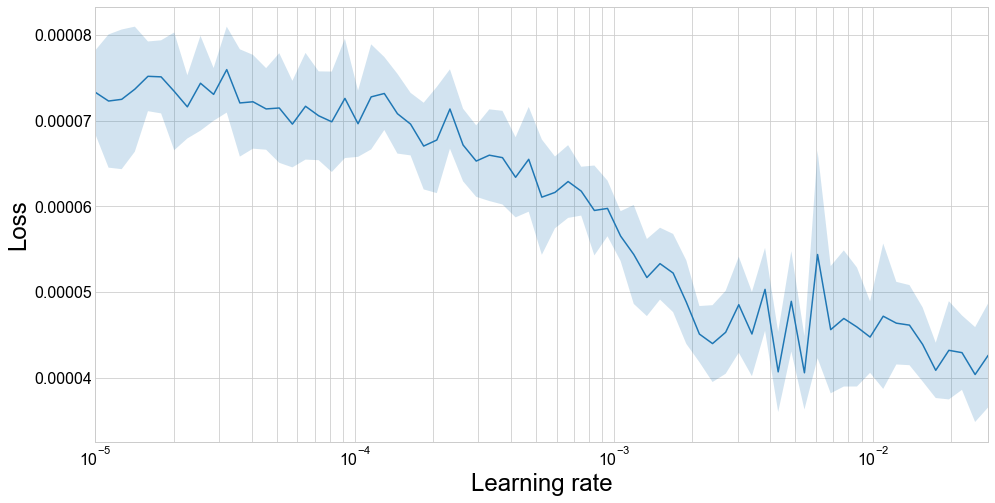

______________________________________



In [5]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

## Train classifier

In [6]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':2e-3}}
use_callbacks = {'CosAnnealLR':{'cycle_mult':2, 'reverse':False, 'redux_decay':True, 'scale':1}}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

Training using weights
Training model 1 / 10
Using cosine LR annealing
2 classes found, running in binary mode

Saving snapshot 1
1 New best found: 3.848938626906602e-05
2 New best found: 3.6010223050834614e-05
Saving snapshot 2
3 New best found: 3.557674583717017e-05
5 New best found: 3.473251554678427e-05
6 New best found: 3.410047331999522e-05
Saving snapshot 3
7 New best found: 3.3905933318601455e-05
12 New best found: 3.34230737600592e-05
13 New best found: 3.296229575353209e-05
14 New best found: 3.280323935759952e-05
Saving snapshot 4
15 New best found: 3.277669777307892e-05
23 New best found: 3.25961574257235e-05
26 New best found: 3.240017518837703e-05
27 New best found: 3.2122919629910026e-05
30 New best found: 3.208870668167947e-05
Saving snapshot 5
31 New best found: 3.2085359141638035e-05
48 New best found: 3.202017566363793e-05
49 New best found: 3.1833047840336806e-05
56 New best found: 3.175948081916431e-05
57 New best found: 3.1758987859939225e-05
58 New best found: 3.

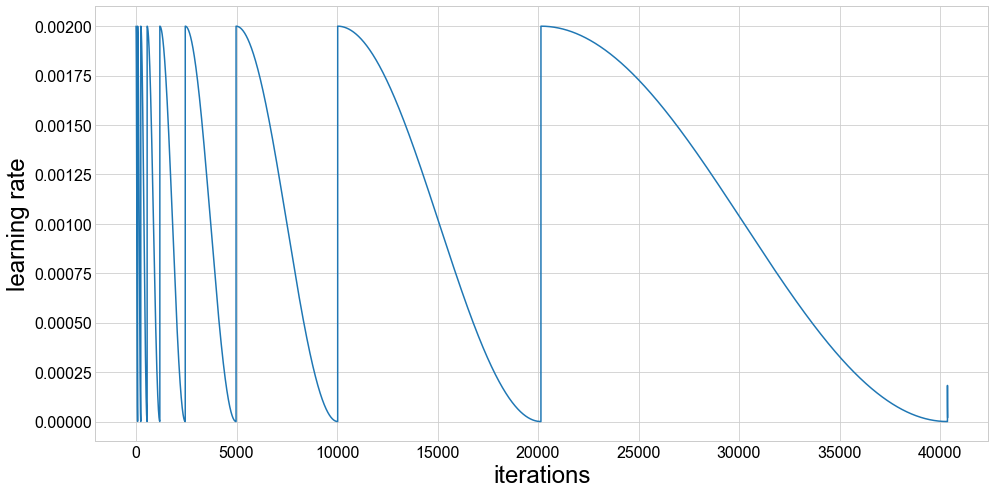

Fold took 288.427s

Training model 2 / 10
Using cosine LR annealing
Saving snapshot 1
1 New best found: 3.9443796811974605e-05
2 New best found: 3.706440398382256e-05
Saving snapshot 2
3 New best found: 3.5582856710243503e-05
4 New best found: 3.523364594584564e-05
5 New best found: 3.423941345099593e-05
6 New best found: 3.388803482812364e-05
Saving snapshot 3
7 New best found: 3.388720989169087e-05
11 New best found: 3.3637307029857765e-05
12 New best found: 3.3524704753654075e-05
13 New best found: 3.314364013203885e-05
14 New best found: 3.3069089644413906e-05
Saving snapshot 4
15 New best found: 3.30470142813283e-05
23 New best found: 3.2930326534551566e-05
25 New best found: 3.2710096366645305e-05
26 New best found: 3.263751809718087e-05
29 New best found: 3.257712729973719e-05
30 New best found: 3.255333824636182e-05
Saving snapshot 5
31 New best found: 3.254873038240476e-05
45 New best found: 3.2507832208648326e-05
48 New best found: 3.248666452418547e-05
50 New best found: 3.2

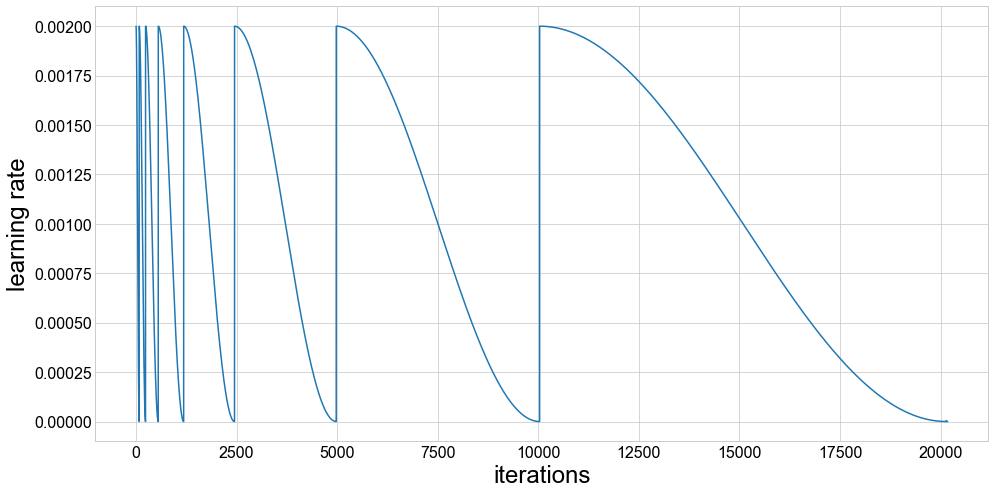

Fold took 160.638s

Training model 3 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102111). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 4.076988438607961e-05
2 New best found: 3.792674003615339e-05
Saving snapshot 2
3 New best found: 3.712448132469954e-05
4 New best found: 3.703716979934578e-05
5 New best found: 3.5993442114667405e-05
6 New best found: 3.556485847658177e-05
Saving snapshot 3
7 New best found: 3.5513730702355e-05
10 New best found: 3.544866314022673e-05
11 New best found: 3.537622573605092e-05
12 New best found: 3.490460164555897e-05
14 New best found: 3.4732341397575444e-05
Saving snapshot 4
15 New best found: 3.4648389707269104e-05
25 New best found: 3.4313726727099093e-05
27 New best found: 3.418642100868801e-05
28 New best found: 3.412125203030943e-05
29 New best found: 3.4060115171539585e-05
Saving snapshot 5
53 New best found: 3.400291322831332e-05
54 New best found: 3.3960220662072524e-05
56 New best found: 3.3786154386161554e-05
Saving snapshot 6
95 New best found: 3.376576284000574e-05
101 New best found: 3.37004588291009e-05
108 New best found: 3.36958678293

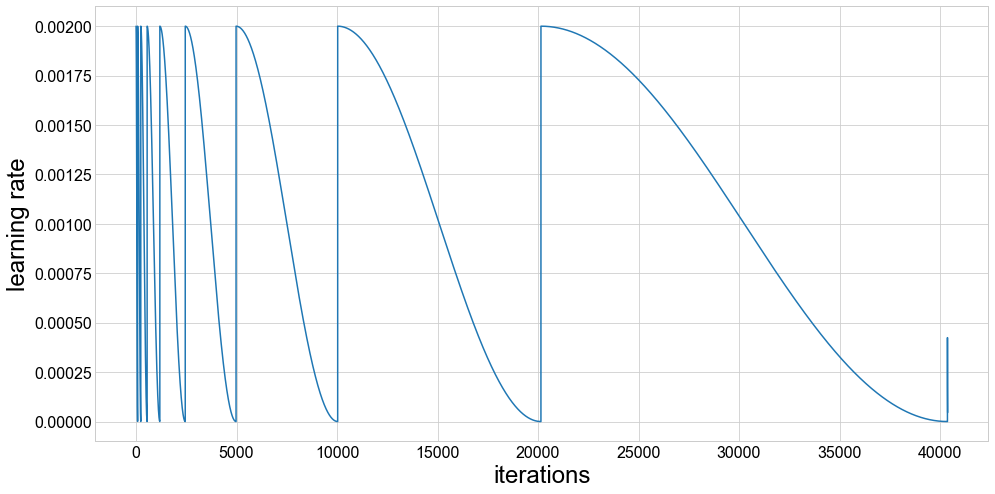

Fold took 369.742s

Training model 4 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109745). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 3.8883379085174574e-05
2 New best found: 3.641041016641566e-05
Saving snapshot 2
3 New best found: 3.588021524787437e-05
4 New best found: 3.557790835397678e-05
5 New best found: 3.500945065220886e-05
6 New best found: 3.3950185915281466e-05
Saving snapshot 3
7 New best found: 3.3948176006663794e-05
10 New best found: 3.3625548538139266e-05
11 New best found: 3.328302309177602e-05
12 New best found: 3.3169553206263954e-05
13 New best found: 3.294288318266407e-05
14 New best found: 3.274356864728645e-05
Saving snapshot 4
15 New best found: 3.270817818698742e-05
26 New best found: 3.2563485467149444e-05
27 New best found: 3.251297566215699e-05
28 New best found: 3.236984583749689e-05
29 New best found: 3.235962065951688e-05
30 New best found: 3.233332324716116e-05
Saving snapshot 5
31 New best found: 3.232405073338842e-05
45 New best found: 3.226766997892551e-05
50 New best found: 3.220687731200537e-05
51 New best found: 3.192957338829776e-05
57 New be

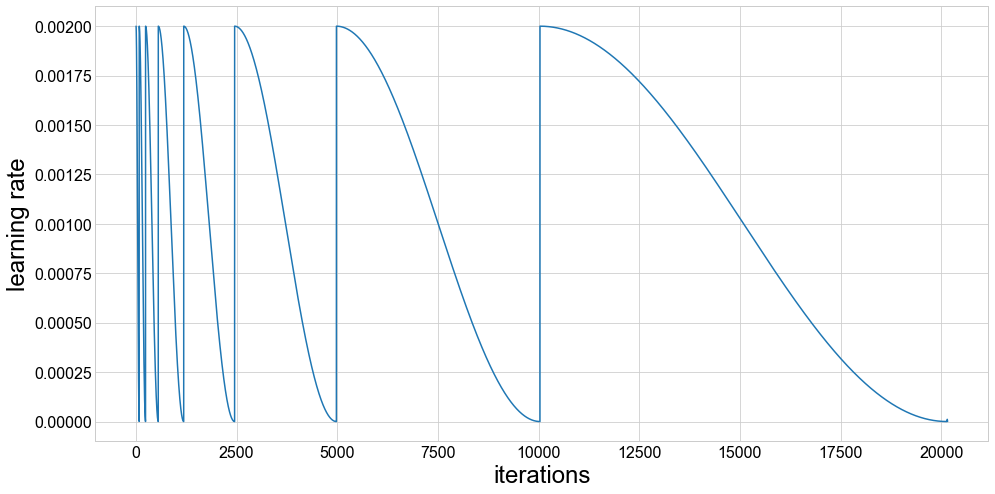

Fold took 158.811s

Training model 5 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118222). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 3.839485526522417e-05
2 New best found: 3.609750337257955e-05
Saving snapshot 2
3 New best found: 3.502386592171345e-05
4 New best found: 3.491358483317942e-05
5 New best found: 3.430607594006685e-05
6 New best found: 3.3859131547289624e-05
Saving snapshot 3
7 New best found: 3.360994826529925e-05
11 New best found: 3.314461969215471e-05
12 New best found: 3.30714154923899e-05
13 New best found: 3.2795064583881124e-05
14 New best found: 3.2734303237750145e-05
Saving snapshot 4
15 New best found: 3.272275715034901e-05
22 New best found: 3.2645817572484664e-05
23 New best found: 3.255443036899698e-05
24 New best found: 3.2425934369706785e-05
25 New best found: 3.2337300477315046e-05
26 New best found: 3.2261028683213284e-05
27 New best found: 3.215492971517561e-05
28 New best found: 3.2084466007083656e-05
29 New best found: 3.200657813380637e-05
30 New best found: 3.1992170820095205e-05
Saving snapshot 5
48 New best found: 3.1856712965888104e-05
53 New

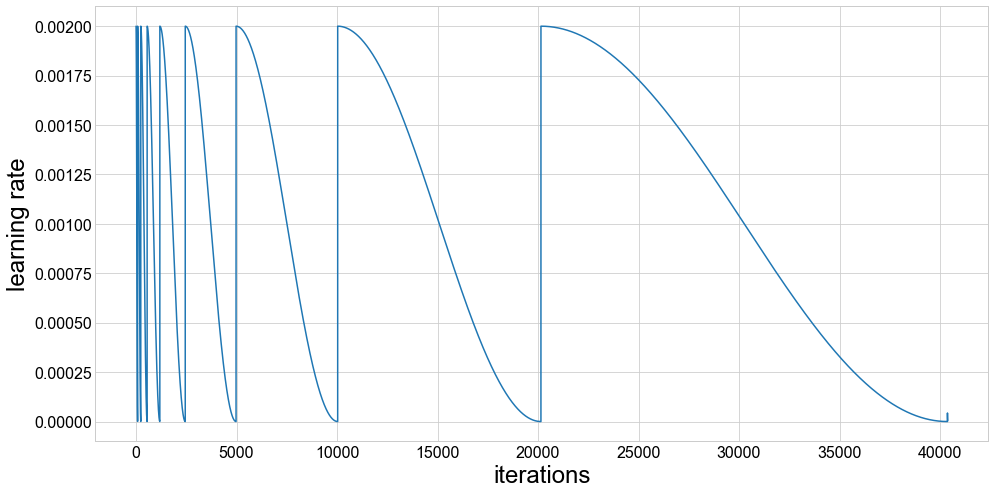

Fold took 313.288s

Training model 6 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121586). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 3.8293991747195835e-05
2 New best found: 3.542053548590047e-05
Saving snapshot 2
3 New best found: 3.4777673255302944e-05
4 New best found: 3.390515095088631e-05
6 New best found: 3.3184647433517964e-05
Saving snapshot 3
7 New best found: 3.306058969319565e-05
9 New best found: 3.287150234973524e-05
10 New best found: 3.280144364689477e-05
12 New best found: 3.256396721117199e-05
13 New best found: 3.2109797844896094e-05
14 New best found: 3.206935026246356e-05
Saving snapshot 4
22 New best found: 3.202441653702408e-05
24 New best found: 3.200240156438667e-05
25 New best found: 3.179568582127103e-05
26 New best found: 3.1688498178846204e-05
28 New best found: 3.1655703784781505e-05
29 New best found: 3.1603648810414596e-05
30 New best found: 3.159547481336631e-05
Saving snapshot 5
31 New best found: 3.158443979918957e-05
49 New best found: 3.1513400386029386e-05
52 New best found: 3.142007870192174e-05
55 New best found: 3.1383352217380886e-05
56 New

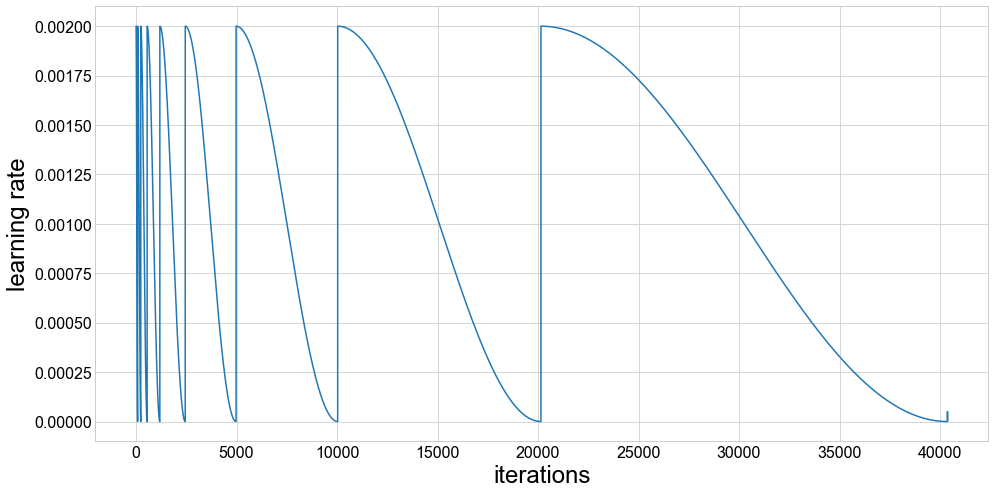

Fold took 317.845s

Training model 7 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.262842). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131798). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 4.0785562779637985e-05
2 New best found: 3.7302370568795596e-05
Saving snapshot 2
3 New best found: 3.652021132729715e-05
4 New best found: 3.5831661349220664e-05
5 New best found: 3.5332093929173426e-05
6 New best found: 3.476715471188072e-05
Saving snapshot 3
7 New best found: 3.4720670341630464e-05
10 New best found: 3.451536553620827e-05
11 New best found: 3.435156149789691e-05
12 New best found: 3.417067450063769e-05
13 New best found: 3.415980908175698e-05
14 New best found: 3.3780434043728746e-05
Saving snapshot 4
15 New best found: 3.375221087480895e-05
23 New best found: 3.35993296263041e-05
26 New best found: 3.3464247504161904e-05
27 New best found: 3.331327411724487e-05
28 New best found: 3.325842422345886e-05
29 New best found: 3.324706934654387e-05
30 New best found: 3.320159536087885e-05
Saving snapshot 5
48 New best found: 3.306062509218464e-05
53 New best found: 3.295259596052347e-05
54 New best found: 3.2885077960963824e-05
57 New b

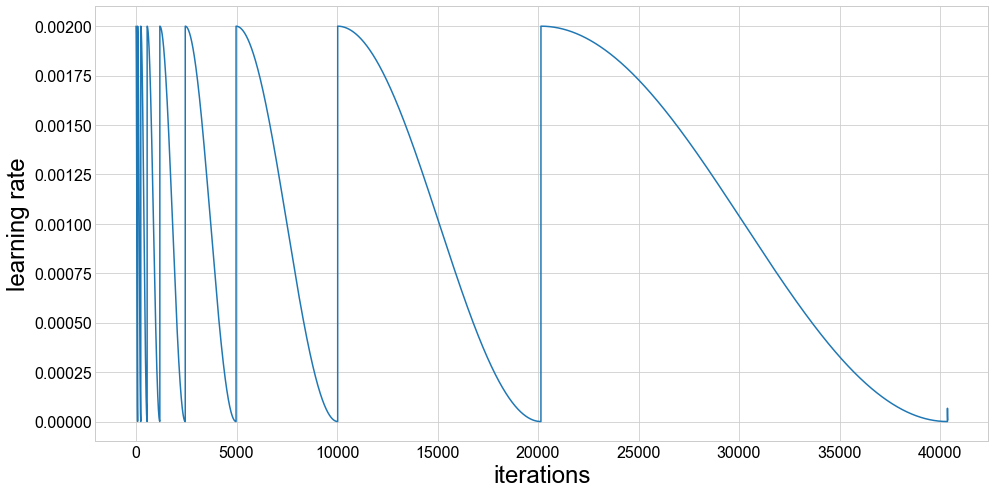

Fold took 325.831s

Training model 8 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.281655). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141139). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 3.984327829867752e-05
2 New best found: 3.6689292454404105e-05
Saving snapshot 2
3 New best found: 3.605744091603105e-05
4 New best found: 3.571080247938592e-05
5 New best found: 3.494924178863909e-05
6 New best found: 3.448181133555817e-05
Saving snapshot 3
7 New best found: 3.432037167166424e-05
11 New best found: 3.429880865199122e-05
12 New best found: 3.360752884319736e-05
Saving snapshot 4
15 New best found: 3.358805354442091e-05
21 New best found: 3.3537519438591994e-05
23 New best found: 3.3314564274938014e-05
24 New best found: 3.3160260887794896e-05
25 New best found: 3.30473884815477e-05
27 New best found: 3.293029511008264e-05
28 New best found: 3.2901487239437716e-05
29 New best found: 3.286034730238263e-05
30 New best found: 3.283333667272016e-05
Saving snapshot 5
31 New best found: 3.282568888860747e-05
50 New best found: 3.28071460819005e-05
51 New best found: 3.269986043076095e-05
52 New best found: 3.258638618885826e-05
55 New best 

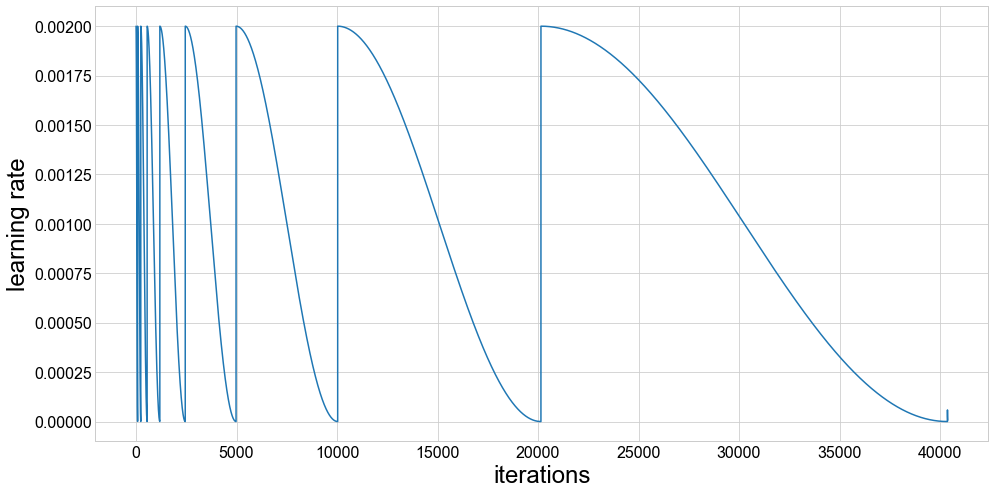

Fold took 337.937s

Training model 9 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.293309). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.146966). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 3.900198812714062e-05
2 New best found: 3.650071053123844e-05
Saving snapshot 2
3 New best found: 3.5929261023205635e-05
4 New best found: 3.546407712934397e-05
5 New best found: 3.484913880644561e-05
6 New best found: 3.4324887245413646e-05
Saving snapshot 3
7 New best found: 3.407222310022384e-05
10 New best found: 3.375786058787731e-05
13 New best found: 3.3243166445938704e-05
14 New best found: 3.316443038860783e-05
Saving snapshot 4
15 New best found: 3.314955087465215e-05
21 New best found: 3.3085122491360634e-05
24 New best found: 3.295244692792771e-05
25 New best found: 3.294184864160443e-05
26 New best found: 3.2767175634518004e-05
27 New best found: 3.255286959550348e-05
29 New best found: 3.251994441529947e-05
30 New best found: 3.2479406542240964e-05
Saving snapshot 5
31 New best found: 3.246898445749835e-05
48 New best found: 3.239102694600491e-05
49 New best found: 3.23150015557968e-05
52 New best found: 3.222044541191201e-05
54 New bes

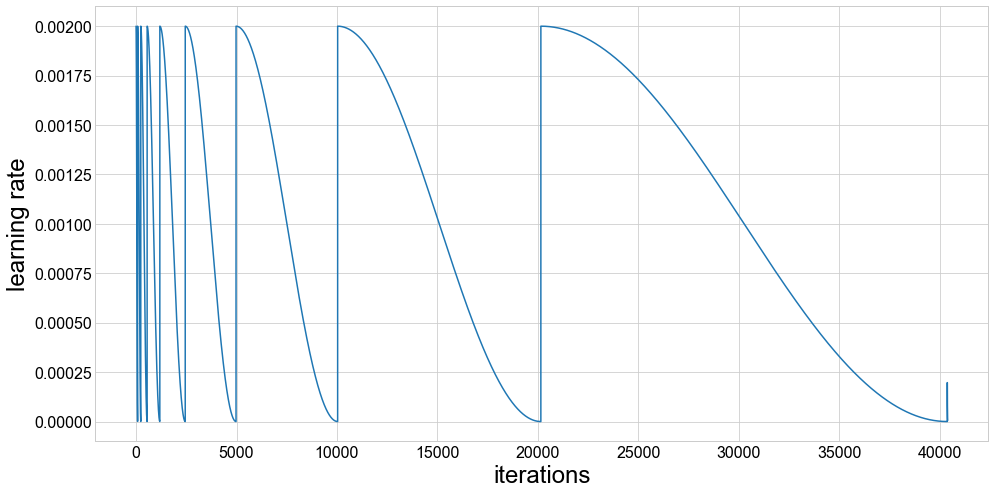

Fold took 347.222s

Training model 10 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.307271). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153994). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 3.9266567208495484e-05
2 New best found: 3.6396546194578066e-05
Saving snapshot 2
3 New best found: 3.566353744476564e-05
5 New best found: 3.47278022800122e-05
6 New best found: 3.423398918922982e-05
Saving snapshot 3
7 New best found: 3.409129163328286e-05
9 New best found: 3.40479708567564e-05
11 New best found: 3.3617278977083995e-05
12 New best found: 3.342562177218478e-05
13 New best found: 3.3193926670180855e-05
14 New best found: 3.307294257404351e-05
Saving snapshot 4
15 New best found: 3.3049828598116635e-05
24 New best found: 3.298262850973692e-05
25 New best found: 3.2827124897970326e-05
26 New best found: 3.273450365880297e-05
27 New best found: 3.27120108038686e-05
28 New best found: 3.267817681387981e-05
29 New best found: 3.263891934974058e-05
30 New best found: 3.259544524689493e-05
Saving snapshot 5
31 New best found: 3.2587551936682066e-05
49 New best found: 3.251300320498204e-05
53 New best found: 3.242548364913507e-05
55 New best

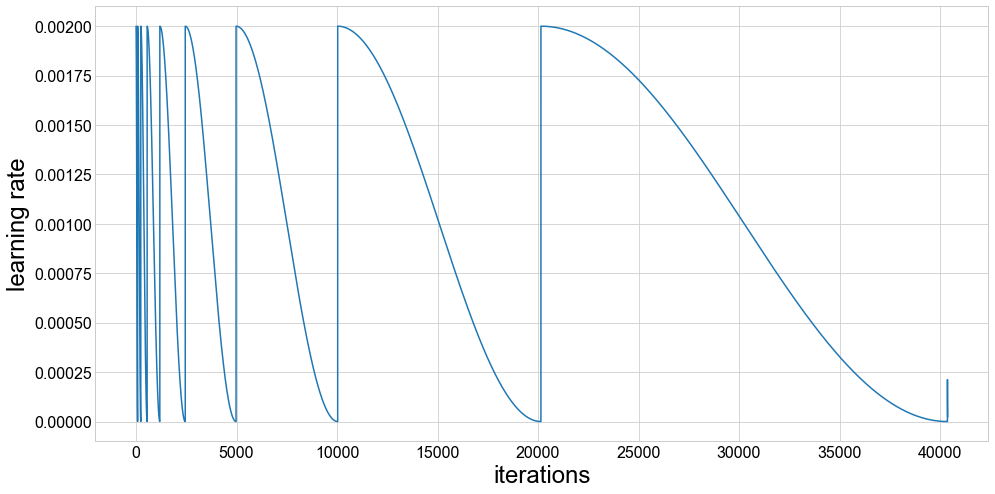

Fold took 351.182s


______________________________________
Training finished
Cross-validation took 2971.067s 


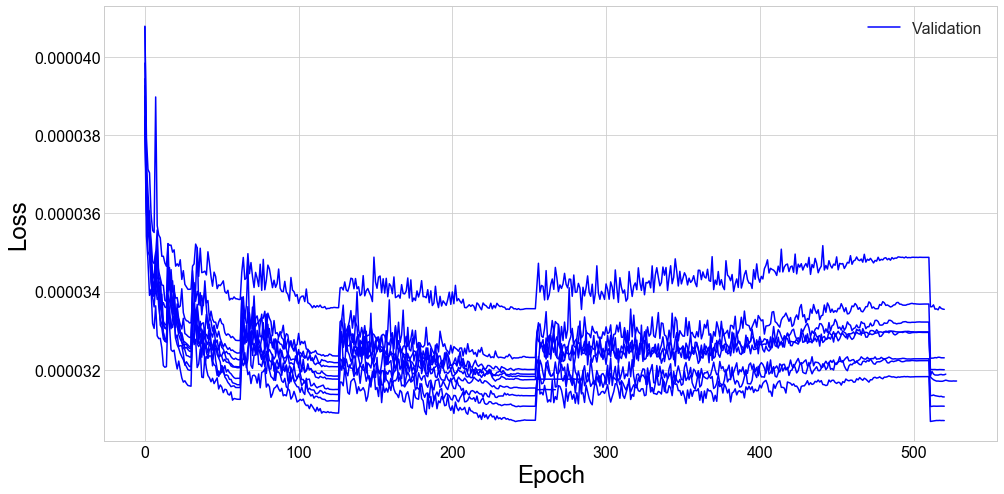

Mean loss = 3.18e-05 +- 2e-07
Mean wAUC = 0.0632 +- 0.0009
Mean AUC = 0.0985 +- 0.0009
Mean AMS = 3.95 +- 0.06
Mean cut = 0.97 +- 0.006
______________________________________



<Figure size 432x288 with 0 Axes>

In [7]:
results, histories, cycle_losses = fold_train_model(train_fy, n_models,
                                                    model_gen_params=model_gen_params,
                                                    train_params=train_params, train_on_weights=True,
                                                    use_callbacks=use_callbacks, ams_args=ams_args,
                                                    max_epochs=max_epochs, patience=patience,
                                                    verbose=1, plots=plots)

## Construct ensemble

In [8]:
with open('train_weights/results_file.pkl', 'rb') as fin:   
    results = pickle.load(fin)
with open('train_weights/cycle_file.pkl', 'rb') as fin:   
    cycle_losses = pickle.load(fin)

In [12]:
ensemble, weights = assemble_ensemble(results, 10)

Choosing ensemble by loss
Model 0 is 5 with loss = 3.068167924429872e-05
Model 1 is 4 with loss = 3.106277799241041e-05
Model 2 is 0 with loss = 3.129600573447533e-05
Model 3 is 3 with loss = 3.1494678560706716e-05
Model 4 is 8 with loss = 3.170995832569567e-05
Model 5 is 1 with loss = 3.17640049601323e-05
Model 6 is 9 with loss = 3.1851799689451395e-05
Model 7 is 7 with loss = 3.198654386759291e-05
Model 8 is 6 with loss = 3.2283332037332005e-05
Model 9 is 2 with loss = 3.351967796502063e-05


## Response on validation data without TTA

In [15]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [16]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0002222883558000831s per sample

Predicting fold 2 out of 10
Prediction took 0.0002178587790000165s per sample

Predicting fold 3 out of 10
Prediction took 0.00020722463759993844s per sample

Predicting fold 4 out of 10
Prediction took 0.00021331567959987296s per sample

Predicting fold 5 out of 10
Prediction took 0.00021726317699994978s per sample

Predicting fold 6 out of 10
Prediction took 0.00021173490719993425s per sample

Predicting fold 7 out of 10
Prediction took 0.00020097250079998048s per sample

Predicting fold 8 out of 10
Prediction took 0.0002096429666000404s per sample

Predicting fold 9 out of 10
Prediction took 0.0002032157264000489s per sample

Predicting fold 10 out of 10
Prediction took 0.000205109862000063s per sample



In [17]:
val_df = convert_to_df(val_fy.source)

50000 candidates loaded


In [18]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df.gen_target, val_df.pred_class),
                                                           roc_auc_score(val_df.gen_target, val_df.pred_class, sample_weight=val_df.gen_weight)))

Testing ROC AUC: unweighted 0.9036565026722946, weighted 0.9361258218265434


/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Best cut at 0.9629005071398493 corresponds to AMS of 3.9107635540912584
Maximum AMS for data is 3.962523345828341 at cut of 0.9619161486625671
CPU times: user 13.4 s, sys: 33.4 ms, total: 13.5 s
Wall time: 13.5 s


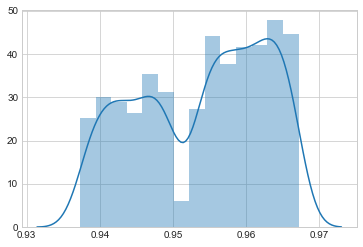

In [19]:
%%time
cut_kde = kde_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

Mean cut at 0.9539207 corresponds to AMS of 3.7773612963369074
Maximum AMS for data is 3.962523345828341 at cut of 0.9619161486625671
CPU times: user 84.6 ms, sys: 11.1 ms, total: 95.7 ms
Wall time: 53 ms


/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


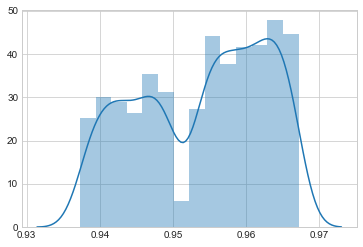

In [20]:
%%time
cut_mean = mean_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

## Response on validation data with TTA

In [21]:
val_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'val.hdf5', "r+"), rot_mult=2, random_rot=True)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


In [22]:
fold_ensemble_predict(ensemble, weights, val_fy, pred_name='pred_TTA', ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.00169392153639983s per sample

Predicting fold 2 out of 10
Prediction took 0.0018220868575999703s per sample

Predicting fold 3 out of 10
Prediction took 0.0017642688136000288s per sample

Predicting fold 4 out of 10
Prediction took 0.0016877058395999484s per sample

Predicting fold 5 out of 10
Prediction took 0.0017685887894000189s per sample

Predicting fold 6 out of 10
Prediction took 0.001690875873600089s per sample

Predicting fold 7 out of 10
Prediction took 0.0016823078572000669s per sample

Predicting fold 8 out of 10
Prediction took 0.0016457958844001042s per sample

Predicting fold 9 out of 10
Prediction took 0.0017029569083999378s per sample

Predicting fold 10 out of 10
Prediction took 0.0016822671215999435s per sample



In [23]:
val_df_tta = convert_to_df(val_fy.source, pred_name='pred_TTA')

50000 candidates loaded


In [24]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df_tta.gen_target, val_df_tta.pred_class),
                                                           roc_auc_score(val_df_tta.gen_target, val_df_tta.pred_class, sample_weight=val_df_tta.gen_weight)))

Testing ROC AUC: unweighted 0.9037923835040862, weighted 0.9362386988958349


/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Best cut at 0.9643164214429196 corresponds to AMS of 3.8561299166698375
Maximum AMS for data is 3.9474371244313575 at cut of 0.9610932469367981
CPU times: user 12.9 s, sys: 13.3 ms, total: 12.9 s
Wall time: 12.9 s


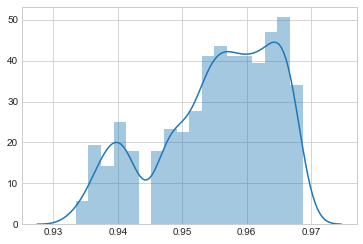

In [25]:
%%time
cut_kde_tta = kde_optimise_cut(val_df_tta, top_perc=0.05, br=10, w_factor=250000/50000)

Mean cut at 0.95530087 corresponds to AMS of 3.8570762335766267
Maximum AMS for data is 3.9474371244313575 at cut of 0.9610932469367981
CPU times: user 102 ms, sys: 12.9 ms, total: 115 ms
Wall time: 52.3 ms


/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


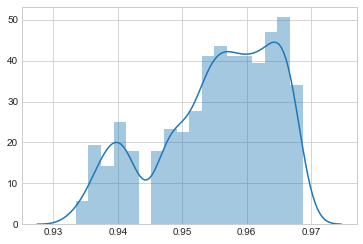

In [26]:
%%time
cut_mean_tta = mean_optimise_cut(val_df_tta, top_perc=0.05, br=10, w_factor=250000/50000)

# Test scoring - Without TTA

In [27]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [28]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.00019550336003635907s per sample

Predicting fold 2 out of 10
Prediction took 0.00019453779310909093s per sample

Predicting fold 3 out of 10
Prediction took 0.00019539627992727962s per sample

Predicting fold 4 out of 10
Prediction took 0.0002040894417090881s per sample

Predicting fold 5 out of 10
Prediction took 0.00019754098596362878s per sample

Predicting fold 6 out of 10
Prediction took 0.00020105734080000482s per sample

Predicting fold 7 out of 10
Prediction took 0.00020304667369091476s per sample

Predicting fold 8 out of 10
Prediction took 0.00020155042047273044s per sample

Predicting fold 9 out of 10
Prediction took 0.00019515380376363862s per sample

Predicting fold 10 out of 10
Prediction took 0.0001953770058727142s per sample

CPU times: user 2min 6s, sys: 16.9 s, total: 2min 23s
Wall time: 1min 49s


In [29]:
score_test_data(test_fy.source, cut_kde)

Public:Private AMS: 3.712656073247911 : 3.784674613966015


(3.712656073247911, 3.784674613966015)

In [30]:
score_test_data(test_fy.source, cut_mean)

Public:Private AMS: 3.824469570578467 : 3.8055945175038164


(3.824469570578467, 3.8055945175038164)

# Test scoring - With TTA

In [31]:
test_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'testing.hdf5', "r+"), rot_mult=2, random_rot=True)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


In [32]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, pred_name='pred_TTA', ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0015973752804727404s per sample

Predicting fold 2 out of 10
Prediction took 0.001598167344890912s per sample

Predicting fold 3 out of 10
Prediction took 0.0016287309882363678s per sample

Predicting fold 4 out of 10
Prediction took 0.0016324854344181817s per sample

Predicting fold 5 out of 10
Prediction took 0.0016180127082363635s per sample

Predicting fold 6 out of 10
Prediction took 0.0016666813340181926s per sample

Predicting fold 7 out of 10
Prediction took 0.0018291091437272783s per sample

Predicting fold 8 out of 10
Prediction took 0.0016962347707454516s per sample

Predicting fold 9 out of 10
Prediction took 0.0016703263037090932s per sample

Predicting fold 10 out of 10
Prediction took 0.001629529533018186s per sample

CPU times: user 17min 30s, sys: 2min 20s, total: 19min 51s
Wall time: 15min 11s


In [33]:
score_test_data(test_fy.source, cut_kde_tta, pred_name='pred_TTA')

Public:Private AMS: 3.653300782114946 : 3.769026677323777


(3.653300782114946, 3.769026677323777)

In [34]:
score_test_data(test_fy.source, cut_mean_tta, pred_name='pred_TTA')

Public:Private AMS: 3.819581902723274 : 3.8167676221088205


(3.819581902723274, 3.8167676221088205)

# Save/Load

In [ ]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)